In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import numpy as np
import scipy.optimize as spo
import wandb
import os
import glob
import torch
from learning_from_data.train import NNTrainingModule
from theoretical_analysis import plot_step_function
from theoretical_analysis.planted_submatrix_analysis import (
    generate_planted_matrix,
    c_critical,
    c_for_step_function,
    compute_free_convolution,
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from pathlib import Path
import matplotlib

log_dir = Path("logs/")
plot_dir = Path("plots/")
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = ["Computer Modern Roman"]
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{mathptmx}"
)

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# sigma=tanh
sigma = lambda x: np.tanh(x)
for tol in [1e-12, 1e-10, 1e-8, 1e-6, 1e-3, 1e-1]:
    print(c_critical(c_range=[0.7, 1.1], sigma=sigma, sigma_image=[-1, 1], tol=1e-12, plot=False))

0.7843413248345315
0.7843413248345315
0.7843413248345315
0.7843413248345315
0.7843413248345315
0.7843413248345315


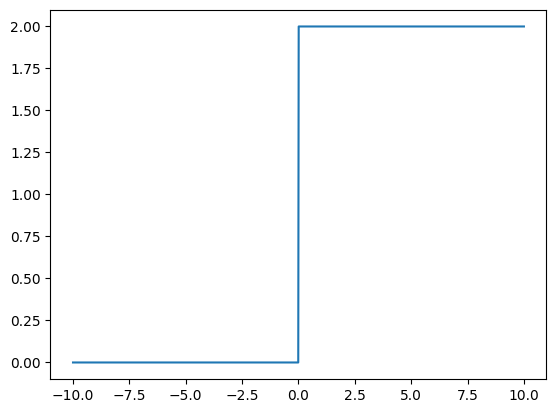

0.8549032247776267
0.8549032248440198
0.8549032256007194
0.8549024581909179
0.8552734375
0.8875


In [4]:
# sigma=sgn(x)+1
plot_step_function([0, 2])
for tol in [1e-12, 1e-10, 1e-8, 1e-6, 1e-3, 1e-1]:
    print(c_for_step_function([0, 2], c_range=[0.7, 1.2], tol=tol, plot=False))

# Explore how shapes affect c_critical
Consider $\sigma(x) = \begin{cases} 0 & x<\gamma_3\\ \gamma_2(\frac{x-\gamma_3}{\gamma_1})^{1/\alpha}& \gamma_3<x<\gamma_1+\gamma_3 \\ \gamma_2 & x>\gamma_1+\gamma_3\end{cases}$

In [2]:
def sigma_3params(x, gamma, alpha=1):
    a, b, c = gamma
    if x < c:
        return 0
    if x >= c and x <= c + a:
        return b * ((x - c) / a) ** (1 / alpha)
    if x > c + a:
        return b

In [3]:
# run blackbox optimization to find best gamma's (fixing alpha=1)
def find_c_for_parametrized_sigma(beta):
    """Given parameter for the parametrized sigma function, compute c_critical."""
    c = c_critical(
        [0.3, 0.9], sigma=lambda x: sigma_3params(x, beta), sigma_image=[0, beta[1]], plot=False
    )
    print(f"beta={beta}, c_critical={c}")
    return c


pickle_file = log_dir / "optimization_result.pkl"
try:
    with open(pickle_file, "rb") as f:
        res = pickle.load(f)
except FileNotFoundError:
    res = spo.minimize(find_c_for_parametrized_sigma, [2, 2, -1], method="Nelder-Mead")
    with open(pickle_file, "wb") as f:
        pickle.dump(res, f)
print(res.fun, res.x)

0.7650237606500015 [ 7.44553623  4.42540863 -5.23367699]


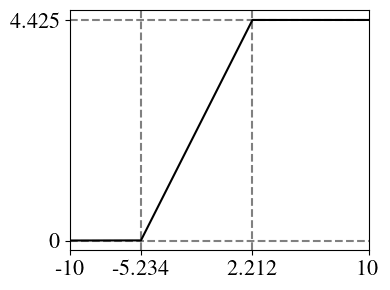

In [6]:
x = np.arange(-10, 10, 0.01)
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(x, [sigma_3params(i, res.x[:3]) for i in x], color="black")
ax.set_xticks([-10, res.x[2], res.x[0] + res.x[2], 10])
ax.set_yticks([0, res.x[1]])
ax.set_xticklabels([-10, f"{res.x[2]:.3f}", f"{res.x[0] + res.x[2]:.3f}", 10], fontsize=16)
ax.set_yticklabels([0, f"{res.x[1]:.3f}"], fontsize=16)

ax.vlines(res.x[2], -0.2, res.x[1] + 0.2, linestyle="--", color="grey", zorder=1)
ax.vlines(res.x[0] + res.x[2], -0.2, res.x[1] + 0.4, linestyle="--", color="gray", zorder=1)
ax.hlines(res.x[1], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(0, -10, 10, linestyle="--", color="gray", zorder=1)
ax.set_ylim(-0.2, res.x[1] + 0.2)
ax.set_xlim(-10, 10)
fig.tight_layout()
fig.savefig(plot_dir / "piecewise_linear_sigma.pdf")
plt.show()
plt.close(fig)

In [80]:
a_range = np.arange(0, 14, 0.5)
b_range = np.arange(0, 11, 0.5)
c_range = np.arange(-10, 3, 0.5)

# fix gamma_3, plot how c_critical changes with gamma_1 and gamma_2
c = res.x[-1]
try:
    available_a, available_b, available_c_criticals = pickle.load(
        open(log_dir / f"c_criticals_c={c}.pkl", "rb")
    )
except FileNotFoundError:
    available_a = []
    available_b = []
c_criticals = np.zeros((len(a_range[:-1]), len(b_range[:-1])))

pbar = tqdm(total=len(a_range[:-1]) * len(b_range[:-1]))
for i, a in enumerate(a_range[:-1]):
    for j, b in enumerate(b_range[:-1]):
        if a in available_a[:-1] and b in available_b[:-1]:
            c_criticals[i, j] = available_c_criticals[
                np.where(available_a == a)[0][0], np.where(available_b == b)[0][0]
            ]
            pbar.update(1)
            continue
        if a == 0:
            c_criticals[i, j] = c_for_step_function(
                beta=[c, b], c_range=[0.5, 1.0], tol=1e-12, plot=False
            )
        else:
            c_criticals[i, j] = c_critical(
                c_range=[0.5, 1.0],
                sigma=lambda x: sigma_3params(x, [a, b, c]),
                sigma_image=[0, b],
                tol=1e-12,
                plot=False,
            )
        pbar.update(1)
pbar.close()
pickle.dump([a_range, b_range, c_criticals], open(log_dir / f"c_criticals_c={c}.pkl", "wb"))

100%|██████████| 567/567 [00:00<00:00, 56398.85it/s]

In [43]:
# fix gamma_1, plot how c_critical changes with gamma_2 and gamma_3
a = res.x[0]
try:
    available_b, available_c, available_c_criticals = pickle.load(
        open(log_dir / f"c_criticals_a={a}.pkl", "rb")
    )
except:
    available_b = []
    available_c = []
c_criticals = np.zeros((len(b_range[:-1]), len(c_range[:-1])))

pbar = tqdm(total=len(b_range[:-1]) * len(c_range[:-1]))
for i, b in enumerate(b_range[:-1]):
    for j, c in enumerate(c_range[:-1]):

        if b in available_b[:-1] and c in available_c[:-1]:
            c_criticals[i, j] = available_c_criticals[
                np.where(available_b == b)[0][0], np.where(available_c == c)[0][0]
            ]
            pbar.update(1)
            continue

        c_criticals[i, j] = c_critical(
            c_range=[0.5, 1.0],
            sigma=lambda x: sigma_3params(x, [a, b, c]),
            sigma_image=[0, b],
            tol=1e-12,
            plot=False,
        )
        pbar.update(1)
pbar.close()
pickle.dump([b_range, c_range, c_criticals], open(log_dir / f"c_criticals_a={a}.pkl", "wb"))

100%|██████████| 525/525 [00:00<00:00, 88253.36it/s]


In [117]:
# fix gamma_2, plot how c_critical changes with gamma_1 and gamma_3
b = res.x[1]
c_criticals = np.zeros((len(a_range[:-1]), len(c_range[:-1])))
try:
    available_a, available_c, available_c_criticals = pickle.load(
        open(log_dir / f"c_criticals_b={b}.pkl", "rb")
    )
except:
    available_a = []
    available_c = []
pbar = tqdm(total=len(a_range[:-1]) * len(c_range[:-1]))
for i, a in enumerate(a_range[:-1]):
    for j, c in enumerate(c_range[:-1]):
        if a in available_a[:-1] and c in available_c[:-1]:
            c_criticals[i, j] = available_c_criticals[
                np.where(available_a == a)[0][0], np.where(available_c == c)[0][0]
            ]
            pbar.update(1)
            continue

        if a == 0:
            c_criticals[i, j] = c_for_step_function(
                beta=[c, b], c_range=[0.5, 1.0], tol=1e-12, plot=False
            )
        else:
            c_criticals[i, j] = c_critical(
                c_range=[0.5, 1.0],
                sigma=lambda x: sigma_3params(x, [a, b, c]),
                sigma_image=[0, b],
                tol=1e-12,
                plot=False,
            )
        pbar.update(1)
pbar.close()
pickle.dump([a_range, c_range, c_criticals], open(log_dir / f"c_criticals_b={b}.pkl", "wb"))

100%|██████████| 675/675 [00:00<00:00, 55716.05it/s]


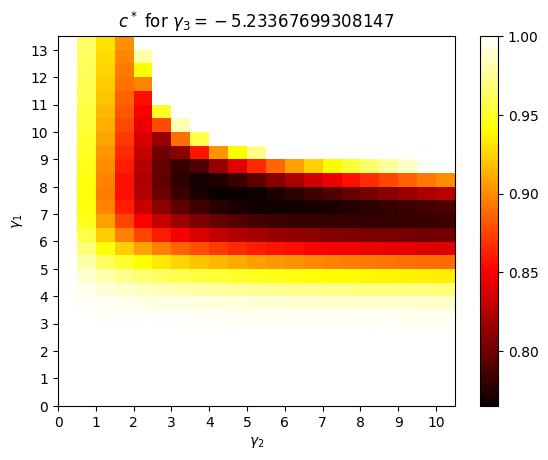

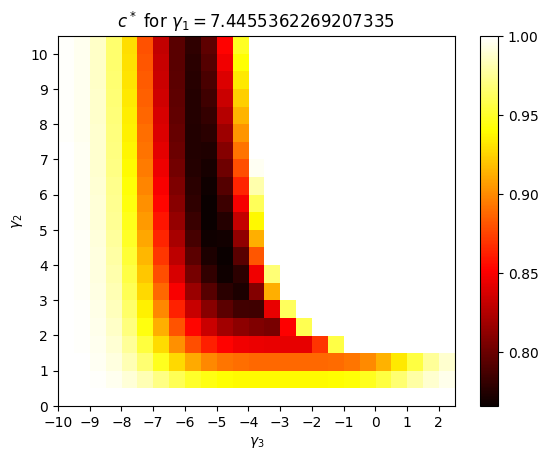

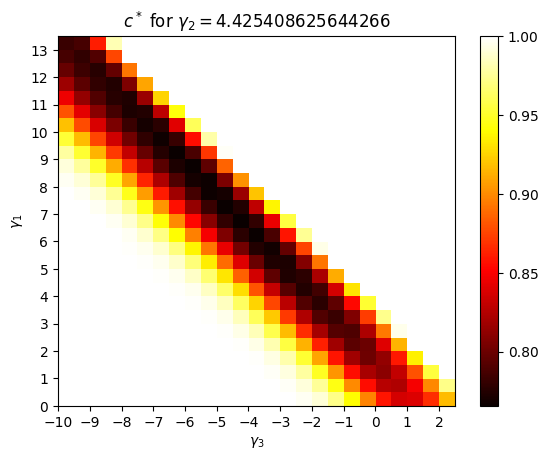

In [118]:
a_range, b_range, fix_c = pickle.load(open(log_dir / f"c_criticals_c={res.x[-1]}.pkl", "rb"))
plt.imshow(
    fix_c,
    extent=[b_range[0], b_range[-1], a_range[0], a_range[-1]],
    origin="lower",
    aspect="auto",
    cmap="hot",
)
plt.xlabel(r"$\gamma_2$")
plt.ylabel(r"$\gamma_1$")
plt.xticks(b_range[::2])
plt.yticks(a_range[::2])
plt.colorbar()
plt.title(rf"$c^*$ for $\gamma_3={res.x[-1]}$")
plt.show()

b_range, c_range, fix_a = pickle.load(open(log_dir / f"c_criticals_a={res.x[0]}.pkl", "rb"))
plt.imshow(
    fix_a,
    extent=[c_range[0], c_range[-1], b_range[0], b_range[-1]],
    origin="lower",
    aspect="auto",
    cmap="hot",
)
plt.colorbar()
plt.xlabel(r"$\gamma_3$")
plt.ylabel(r"$\gamma_2$")
plt.xticks(c_range[::2])
plt.yticks(b_range[::2])
plt.title(rf"$c^*$ for $\gamma_1={res.x[0]}$")
plt.show()

a_range, c_range, fix_b = pickle.load(open(log_dir / f"c_criticals_b={res.x[1]}.pkl", "rb"))
plt.imshow(
    fix_b,
    extent=[c_range[0], c_range[-1], a_range[0], a_range[-1]],
    origin="lower",
    aspect="auto",
    cmap="hot",
)
plt.colorbar()
plt.xlabel(r"$\gamma_3$")
plt.ylabel(r"$\gamma_1$")
plt.xticks(c_range[::2])
plt.yticks(a_range[::2])
plt.title(rf"$c^*$ for $\gamma_2={res.x[1]}$")
plt.show()

Text(0.5, 1.0, '$c^*$ for different $\\alpha$')

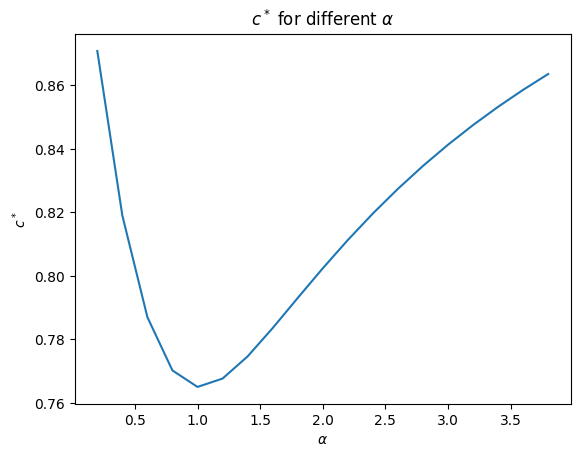

In [119]:
# fix the best gamma's, plot how c_critical changes with alpha
alpha_range = np.arange(0.2, 4, 0.2)
c_criticals = np.zeros(len(alpha_range))
try:
    available_alpha, available_c_criticals = pickle.load(
        open(log_dir / f"c_criticals_alpha.pkl", "rb")
    )
except FileNotFoundError:
    available_alpha = []
    available_c_criticals = []

for i, alpha in enumerate(alpha_range):
    if alpha in available_alpha:
        c_criticals[i] = available_c_criticals[np.where(available_alpha == alpha)[0][0]]
    sigma = lambda x: sigma_3params(x, res.x, alpha=alpha)
    c_criticals[i] = c_critical(
        c_range=[0.5, 1.0], sigma=sigma, sigma_image=[0, res.x[1]], tol=1e-12, plot=False
    )
pickle.dump([alpha_range, c_criticals], open(log_dir / f"c_criticals_alpha.pkl", "wb"))

plt.plot(alpha_range, c_criticals)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$c^*$")
plt.title(r"$c^*$ for different $\alpha$")

/cis/home/yma93/projects/gnn-planted-clique/theoretical_analysis/planted_submatrix_analysis.py:10: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return spi.quad(


Text(0.5, 1.0, '$c^*$ for different $\\alpha$')

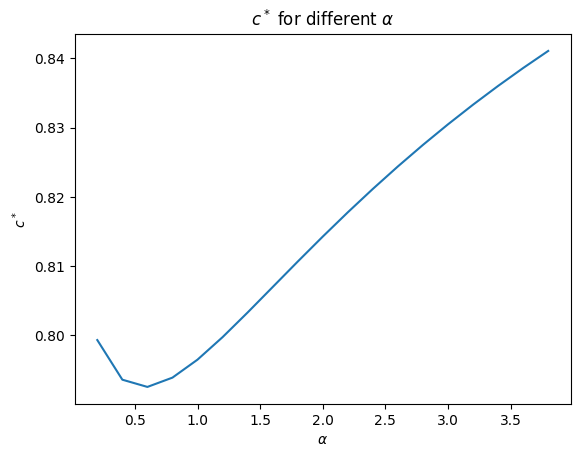

In [65]:
# try a different set of gamma; varying alpha
c_criticals = np.zeros(len(alpha_range))
for i, alpha in enumerate(alpha_range):
    c_criticals[i] = c_critical(
        c_range=[0.5, 1.5],
        sigma=lambda x: sigma_3params(x, [2, 2, -1], alpha=alpha),
        sigma_image=[0, 2],
        tol=1e-12,
        plot=False,
    )

plt.plot(alpha_range, c_criticals)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$c^*$")
plt.title(r"$c^*$ for different $\alpha$")

Text(0.5, 1.0, '$c^*$ for different $\\alpha$')

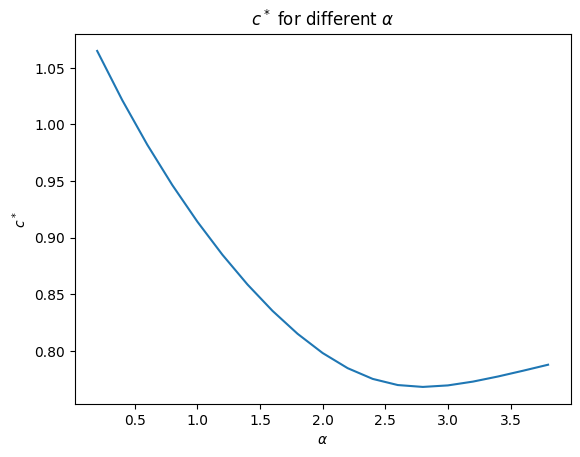

In [68]:
c_criticals = np.zeros(len(alpha_range))
for i, alpha in enumerate(alpha_range):
    c_criticals[i] = c_critical(
        c_range=[0.5, 1.5],
        sigma=lambda x: sigma_3params(x, [8, 8, -5], alpha=alpha),
        sigma_image=[0, 8],
        tol=1e-12,
        plot=False,
    )

plt.plot(alpha_range, c_criticals)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$c^*$")
plt.title(r"$c^*$ for different $\alpha$")

In [120]:
# run blackbox optimization for gamma and alpha
def find_c_for_parametrized_sigma(beta):
    """Given parameter for the parametrized sigma function, compute c_critical."""
    c = c_critical(
        [0.3, 0.9],
        sigma=lambda x: sigma_3params(x, beta[:3], beta[-1]),
        sigma_image=[0, beta[1]],
        plot=False,
    )
    print(f"beta={beta}, c_critical={c}")
    return c


pickle_file = log_dir / "optimization_result_gamma_alpha.pkl"
try:
    with open(pickle_file, "rb") as f:
        res = pickle.load(f)
except FileNotFoundError:
    res = spo.minimize(find_c_for_parametrized_sigma, [2, 2, -1, 1], method="Nelder-Mead")
    with open(pickle_file, "wb") as f:
        pickle.dump(res, f)

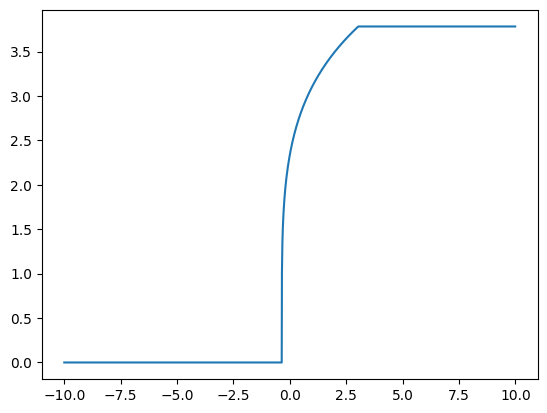

In [121]:
x = np.arange(-10, 10, 0.01)
plt.plot(x, [sigma_3params(i, res.x[:3], res.x[-1]) for i in x])
plt.show()

# $a\tanh(bx)$

## Blackbox optimization for best a,b

In [3]:
def c_for_parametrized_tanh(beta):
    """Given parameter for the parametrized sigma function, compute c_critical."""
    sigma = lambda x: beta[0] * np.tanh(beta[1] * x)
    sigma_image = [-beta[0], beta[0]]
    c = c_critical([0.3, 0.9], sigma=sigma, sigma_image=sigma_image, plot=False)
    return c


try:
    with open(log_dir / "optimization_result_tanh.pkl", "rb") as f:
        res = pickle.load(f)
except FileNotFoundError:
    res = spo.minimize(c_for_parametrized_tanh, [1.0, 1.0], method="Nelder-Mead")
    with open(log_dir / "optimization_result_tanh.pkl", "wb") as f:
        pickle.dump(res, f)

In [4]:
res.fun, res.x

(0.7550073893002265, array([1.70974534, 0.58384117]))

In [5]:
def tanh_sigma(x, gamma):
    return gamma[0] * np.tanh(gamma[1] * x)

## Plots for learned sigma and eigenvalue histograms

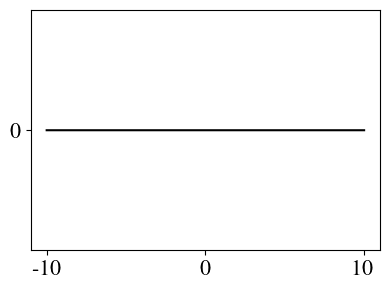

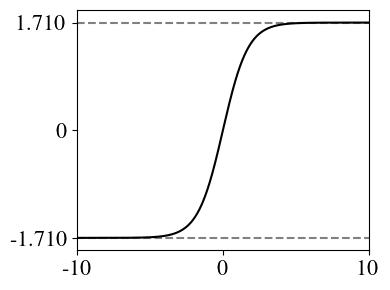

In [11]:
# plot zero sigma and learned sigma
x = np.arange(-10, 10, 0.01)

# Plot zero sigma
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x, np.zeros_like(x), color="black")
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$\sigma(x)$")
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=16)
ax.set_yticks([0])
ax.set_yticklabels([0], fontsize=16)

fig.tight_layout()
fig.savefig(plot_dir / "zero_sigma.pdf")
plt.show()
plt.close(fig)

# Plot learned sigma
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x, res.x[0] * np.tanh(res.x[1] * x), color="black")
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$\sigma(x)$")
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=16)
ax.set_yticks([-res.x[0], 0, res.x[0]])
ax.set_yticklabels([f"{-res.x[0]:.3f}", "0", f"{res.x[0]:.3f}"], fontsize=16)
ax.hlines(-res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.set_xlim(-10, 10)
ax.set_ylim(-res.x[0] - 0.2, res.x[0] + 0.2)
fig.tight_layout()
fig.savefig(plot_dir / "learned_sigma.pdf")
plt.show()
plt.close(fig)

[1.98482178 1.98791447 1.99015747 1.99201934 1.99445959] [2.54399955 2.54755067 2.54993592 2.55374766 2.56801767]


/tmp/ipykernel_3056611/4193971885.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


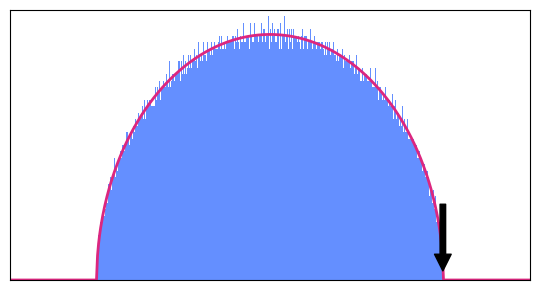

/tmp/ipykernel_3056611/4193971885.py:68: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


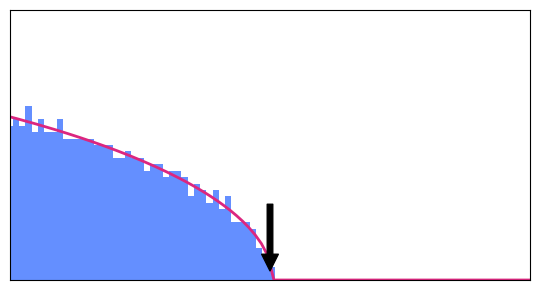

/tmp/ipykernel_3056611/4193971885.py:94: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


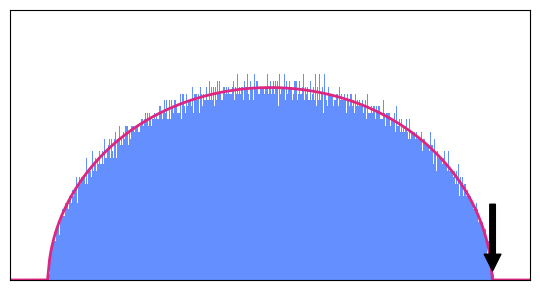

/tmp/ipykernel_3056611/4193971885.py:120: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


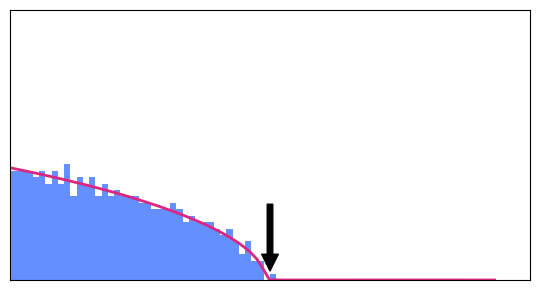

[1.98638185 1.98784279 1.99065044 1.99353072 2.00432433] [2.55567645 2.55607467 2.56114613 2.56722468 2.61152794]


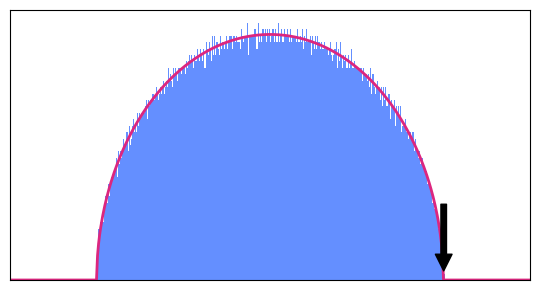

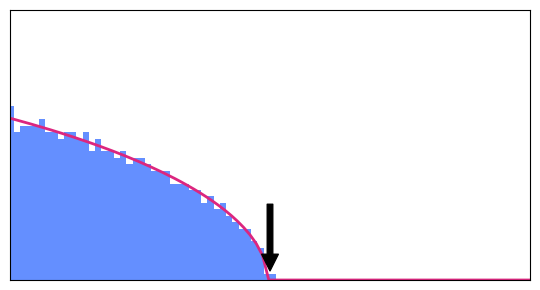

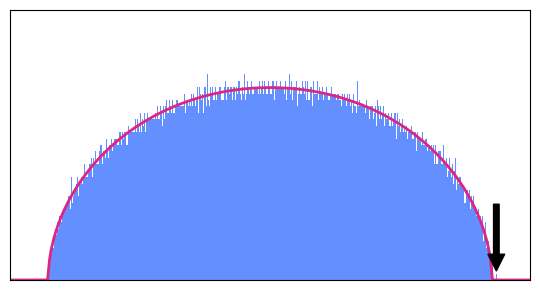

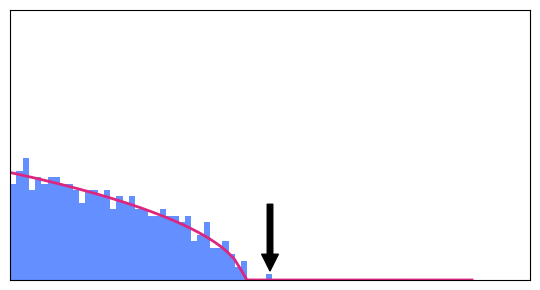

[1.98220826 1.98561217 1.98743747 1.99268059 2.03171579] [2.55826293 2.55930212 2.56621592 2.57088286 2.86079064]


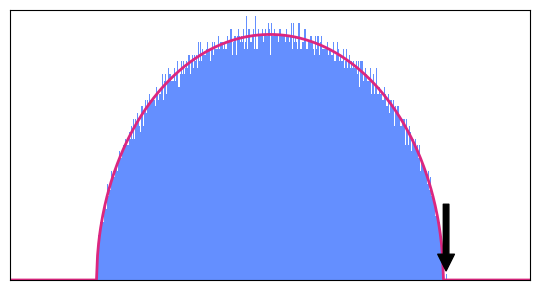

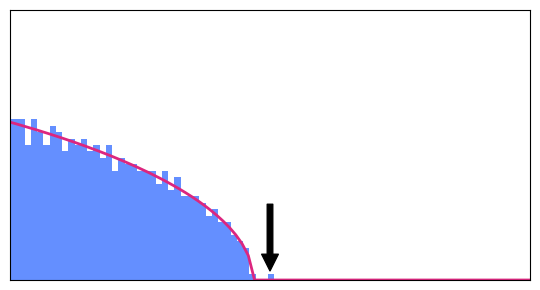

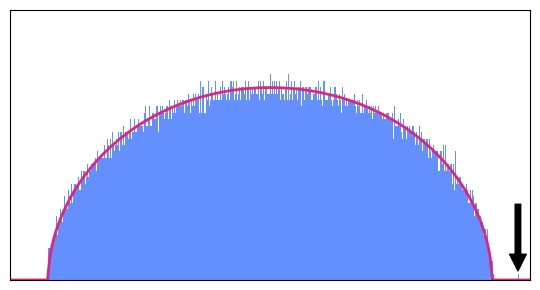

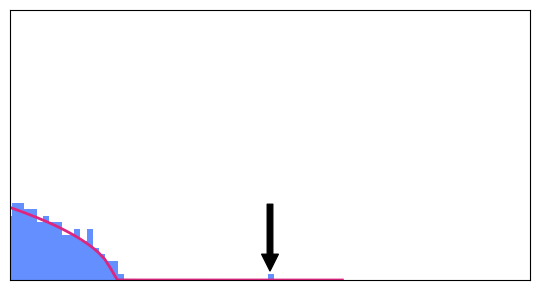

In [41]:
n = 10000
np.random.seed(0)
for beta in [0, 0.9, 1.2]:
    try:
        A_p_evals, L_p_evals = pickle.load(open(log_dir / f"eigenvalues_beta={beta}.pkl", "rb"))
    except FileNotFoundError:
        A_p, _ = generate_planted_matrix(n, int(np.sqrt(n) * beta))
        A_p_evals = np.linalg.eigvalsh(A_p)
        L_p = A_p + np.diag(tanh_sigma(A_p.sum(axis=1), res.x))
        L_p_evals = np.linalg.eigvalsh(L_p)
        pickle.dump([A_p_evals, L_p_evals], open(log_dir / f"eigenvalues_beta={beta}.pkl", "wb"))
    print(A_p_evals[-5:], L_p_evals[-5:])
    x = np.linspace(-3, 3, 500)
    sc = np.sqrt(np.maximum(4 - x**2, 0)) / (2 * np.pi)
    try:
        free_conv = pickle.load(open(log_dir / f"free_conv_beta={beta}.pkl", "rb"))
    except FileNotFoundError:
        free_conv = compute_free_convolution(sigma=lambda x: tanh_sigma(x, res.x), zs_x=x)
        pickle.dump(free_conv, open(log_dir / f"free_conv_beta={beta}.pkl", "wb"))

    # Original figure for A_p_evals
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        A_p_evals,
        bins=500,
        density=True,
        color="#648FFF",
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(A_p_evals[-1], 0.01),
        xytext=(A_p_evals[-1], 0.1),
        arrowprops=dict(facecolor="black", shrink=0.02),
    )
    ax.plot(x, sc, label="Analytic prediction", color="#dc267f", linewidth=2)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(plot_dir / f"direct_beta={beta}.pdf")
    plt.show()
    plt.close(fig)

    # Zoomed-in figure for A_p_evals
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        A_p_evals,
        bins=500,
        density=True,
        color="#648FFF",
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(A_p_evals[-1], 0.01),
        xytext=(A_p_evals[-1], 0.1),
        arrowprops=dict(facecolor="black", shrink=0.02),
    )
    ax.plot(x, sc, label="Analytic prediction", color="#dc267f", linewidth=2)
    ax.set_xlim(A_p_evals[-1] - 0.5, A_p_evals[-1] + 0.5)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(plot_dir / f"direct_beta={beta}_zoomed.pdf")
    plt.show()
    plt.close(fig)

    # Original figure for L_p_evals
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        L_p_evals,
        bins=500,
        density=True,
        color="#648FFF",
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(L_p_evals[-1], 0.01),
        xytext=(L_p_evals[-1], 0.1),
        arrowprops=dict(facecolor="black", shrink=0.02),
    )
    ax.plot(x, free_conv, label="Analytic prediction", color="#dc267f", linewidth=2)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(plot_dir / f"sigma_beta={beta}.pdf")
    plt.show()
    plt.close(fig)

    # Zoomed-in figure for L_p_evals
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        L_p_evals,
        bins=500,
        density=True,
        color="#648FFF",
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(L_p_evals[-1], 0.01),
        xytext=(L_p_evals[-1], 0.1),
        arrowprops=dict(facecolor="black", shrink=0.02),
    )
    ax.plot(x, free_conv, label="Analytic prediction", color="#dc267f", linewidth=2)
    ax.set_xlim(L_p_evals[-1] - 0.5, L_p_evals[-1] + 0.5)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(plot_dir / f"sigma_beta={beta}_zoomed.pdf")
    plt.show()
    plt.close(fig)

In [37]:
0.35 / 12

0.029166666666666664

[1.98482178 1.98791447 1.99015747 1.99201934 1.99445959] [2.54399955 2.54755067 2.54993592 2.55374766 2.56801767]


/tmp/ipykernel_3056611/2683596043.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3056611/2683596043.py:68: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


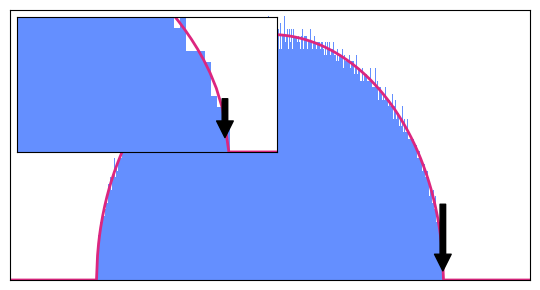

/tmp/ipykernel_3056611/2683596043.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3056611/2683596043.py:116: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


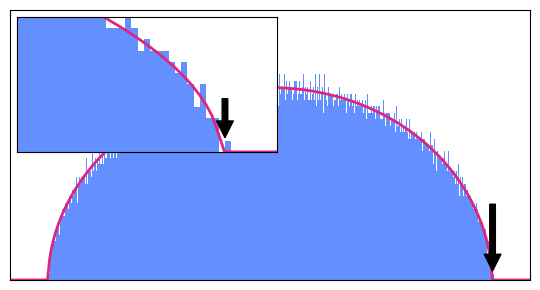

[1.98638185 1.98784279 1.99065044 1.99353072 2.00432433] [2.55567645 2.55607467 2.56114613 2.56722468 2.61152794]


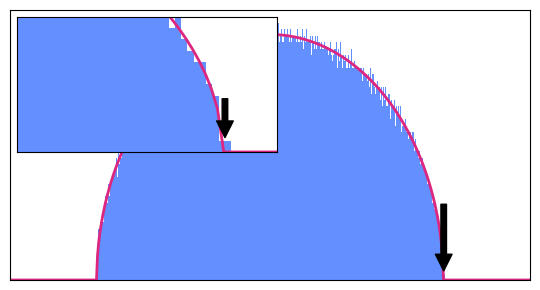

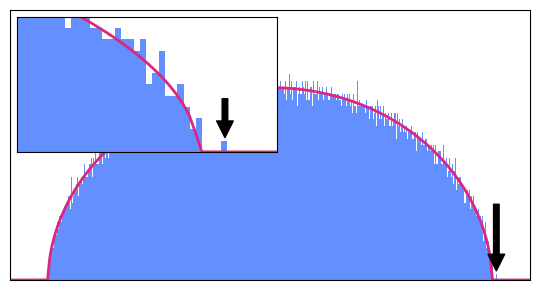

[1.98220826 1.98561217 1.98743747 1.99268059 2.03171579] [2.55826293 2.55930212 2.56621592 2.57088286 2.86079064]


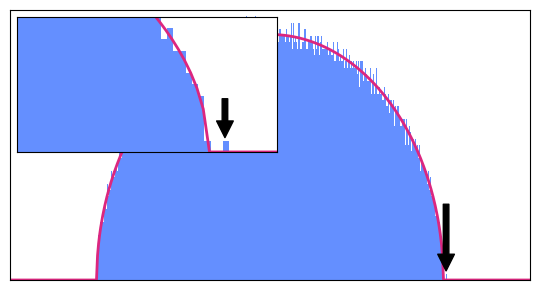

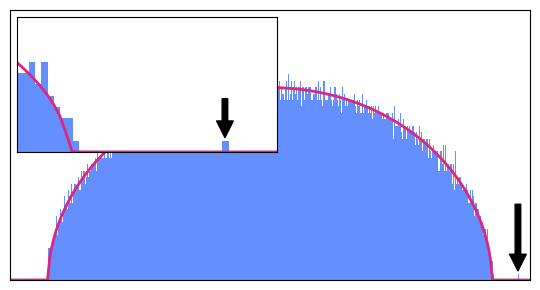

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

n = 10000
np.random.seed(0)
for beta in [0, 0.9, 1.2]:
    try:
        A_p_evals, L_p_evals = pickle.load(open(log_dir / f"eigenvalues_beta={beta}.pkl", "rb"))
    except FileNotFoundError:
        A_p, _ = generate_planted_matrix(n, int(np.sqrt(n) * beta))
        A_p_evals = np.linalg.eigvalsh(A_p)
        L_p = A_p + np.diag(tanh_sigma(A_p.sum(axis=1), res.x))
        L_p_evals = np.linalg.eigvalsh(L_p)
        pickle.dump([A_p_evals, L_p_evals], open(log_dir / f"eigenvalues_beta={beta}.pkl", "wb"))
    print(A_p_evals[-5:], L_p_evals[-5:])
    x = np.linspace(-3, 3, 500)
    sc = np.sqrt(np.maximum(4 - x**2, 0)) / (2 * np.pi)
    try:
        free_conv = pickle.load(open(log_dir / f"free_conv_beta={beta}.pkl", "rb"))
    except FileNotFoundError:
        free_conv = compute_free_convolution(sigma=lambda x: tanh_sigma(x, res.x), zs_x=x)
        pickle.dump(free_conv, open(log_dir / f"free_conv_beta={beta}.pkl", "wb"))

    # Original figure for A_p_evals with inset
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        A_p_evals,
        bins=500,
        density=True,
        color="#648FFF",
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(A_p_evals[-1], 0.01),
        xytext=(A_p_evals[-1], 0.1),
        arrowprops=dict(facecolor="black", shrink=0.02),
    )
    ax.plot(x, sc, label="Analytic prediction", color="#dc267f", linewidth=2)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])

    # Inset for zoomed-in A_p_evals
    ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper left")
    ax_inset.hist(
        A_p_evals,
        bins=500,
        density=True,
        color="#648FFF",
        range=(-3, 3),
    )
    ax_inset.annotate(
        "",
        xy=(A_p_evals[-1], 0.01),
        xytext=(A_p_evals[-1], 0.04),
        arrowprops=dict(facecolor="black", shrink=0.02),
    )
    ax_inset.plot(x, sc, color="#dc267f", linewidth=2)
    ax_inset.set_xlim(A_p_evals[-1] - 0.4, A_p_evals[-1] + 0.1)
    ax_inset.set_ylim(0, 0.1)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    fig.tight_layout()
    fig.savefig(plot_dir / f"direct_beta={beta}_combined.pdf")
    plt.show()
    plt.close(fig)

    # Original figure for L_p_evals with inset
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        L_p_evals,
        bins=500,
        density=True,
        color="#648FFF",
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(L_p_evals[-1], 0.01),
        xytext=(L_p_evals[-1], 0.1),
        arrowprops=dict(facecolor="black", shrink=0.02),
    )
    ax.plot(x, free_conv, label="Analytic prediction", color="#dc267f", linewidth=2)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])

    # Inset for zoomed-in L_p_evals
    ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper left")
    ax_inset.hist(
        L_p_evals,
        bins=500,
        density=True,
        color="#648FFF",
        range=(-3, 3),
    )
    ax_inset.annotate(
        "",
        xy=(L_p_evals[-1], 0.01),
        xytext=(L_p_evals[-1], 0.04),
        arrowprops=dict(facecolor="black", shrink=0.02),
    )
    ax_inset.plot(x, free_conv, color="#dc267f", linewidth=2)
    ax_inset.set_xlim(L_p_evals[-1] - 0.4, L_p_evals[-1] + 0.1)
    ax_inset.set_ylim(0, 0.1)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])

    fig.tight_layout()
    fig.savefig(plot_dir / f"sigma_beta={beta}_combined.pdf")
    plt.show()
    plt.close(fig)

## Phase transition for eigenvalue and eigenvectors

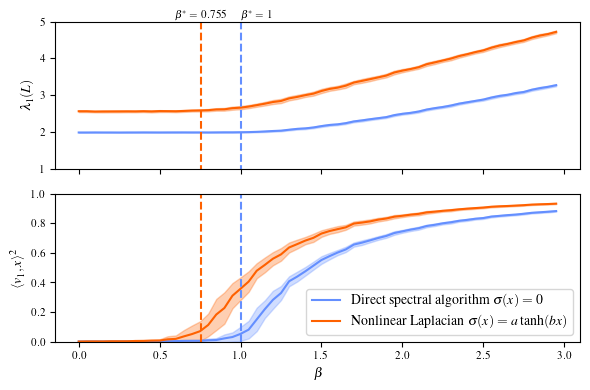

In [62]:
n = 2000
N = 100
np.random.seed(0)
betas = np.arange(0, 3, 0.05)
try:
    results = pickle.load(open(log_dir / f"top_eigen_n={n}_N={N}.pkl", "rb"))
except FileNotFoundError:
    results = {}
for beta in betas:
    if beta in results:
        continue

    A_p_evals = np.zeros(N)
    L_p_evals = np.zeros(N)
    A_p_evecs = np.zeros(N)
    L_p_evecs = np.zeros(N)

    for i in range(N):
        A_p, y = generate_planted_matrix(n, int(np.sqrt(n) * beta))
        eval, evec = np.linalg.eigh(A_p)
        A_p_evals[i], A_p_evecs[i] = eval[-1], (evec[:, -1] * y).sum() ** 2

        L_p = A_p + np.diag(tanh_sigma(A_p.sum(axis=1), res.x))
        eval, evec = np.linalg.eigh(L_p)
        L_p_evals[i], L_p_evecs[i] = eval[-1], (evec[:, -1] * y).sum() ** 2

    results[beta] = [A_p_evals, A_p_evecs, L_p_evals, L_p_evecs]
    pickle.dump(results, open(log_dir / f"top_eigen_n={n}_N={N}.pkl", "wb"))
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
ax[0].plot(
    betas,
    [results[beta][0].mean() for beta in betas],
    label=r"Direct spectral algorithm $\sigma(x)=0$",
    color="#648fff",
)
ax[0].fill_between(
    betas,
    [results[beta][0].mean() - results[beta][0].std() for beta in betas],
    [results[beta][0].mean() + results[beta][0].std() for beta in betas],
    alpha=0.3,
    color="#648fff",
)
ax[0].plot(
    betas,
    [results[beta][2].mean() for beta in betas],
    label=r"Nonlinear Laplacian $\sigma(x)=a\tanh(bx)$",
    color="#fe6100",
)
ax[0].fill_between(
    betas,
    [results[beta][2].mean() - results[beta][2].std() for beta in betas],
    [results[beta][2].mean() + results[beta][2].std() for beta in betas],
    alpha=0.3,
    color="#fe6100",
)
ax[1].plot(
    betas,
    [results[beta][1].mean() for beta in betas],
    label=r"Direct spectral algorithm $\sigma(x)=0$",
    color="#648fff",
)
ax[1].fill_between(
    betas,
    [results[beta][1].mean() - results[beta][1].std() for beta in betas],
    [results[beta][1].mean() + results[beta][1].std() for beta in betas],
    alpha=0.3,
    color="#648fff",
)
ax[1].plot(
    betas,
    [results[beta][3].mean() for beta in betas],
    label=r"Nonlinear Laplacian $\sigma(x)=a\tanh(bx)$",
    color="#fe6100",
)
ax[1].fill_between(
    betas,
    [results[beta][3].mean() - results[beta][3].std() for beta in betas],
    [results[beta][3].mean() + results[beta][3].std() for beta in betas],
    alpha=0.3,
    color="#fe6100",
)

ax[0].vlines(1, 0, 5, linestyle="--", color="#648fff")
ax[0].vlines(res.fun, 0, 5, linestyle="--", color="#fe6100")
ax[1].vlines(1, 0, 1, linestyle="--", color="#648fff")
ax[1].vlines(res.fun, 0, 1, linestyle="--", color="#fe6100")

ax[0].text(1, 5.1, r"$\beta^*=1$", color="black", ha="left", fontsize=8)
ax[0].text(res.fun, 5.1, rf"$\beta^*={res.fun:.3f}$", color="black", ha="center", fontsize=8)

ax[0].set_ylim(1, 5)
ax[1].set_ylim(0, 1)
ax[0].set_ylabel(r"$\lambda_1(L)$")
ax[1].set_ylabel(r"$\langle {v}_1, {x} \rangle^2$")
ax[1].set_xlabel(r"$\beta$")
ax[0].set_xticklabels([])
ax[1].tick_params(axis="x", labelsize=8)
ax[0].tick_params(axis="y", labelsize=8)
ax[1].tick_params(axis="y", labelsize=8)

plt.legend(loc="lower right")
plt.savefig(plot_dir / "eigenvectors.pdf")
plt.tight_layout()
plt.show()

# Black box optimizaiton for step functions

#### Nelder-Mead Optimization

In [5]:
def minimize_with_random_initial_simplex(n=20, seed=0):
    # define bounds for the parameters in optimization
    bounds = (
        [(None, None)] + [(0, None) for _ in range(1, n + 1)] + [(0, None) for _ in range(0, n + 1)]
    )
    # define initial simplex for Nelder-Mead
    rng = np.random.default_rng(seed)
    N = 2 * n + 2  # N parameters, need N+1 points to define the initial simplex
    simplex = rng.uniform(
        0, 1, (N + 1, N)
    )  # set each incremental parameter to be uniformly random in [0,1]
    simplex[:, 0] = rng.uniform(
        -5, 0, N + 1
    )  # set x0(the first parameter) to be uniformly random in [-5,0]
    # run minimization
    historic_xks = []
    historic_funs = []

    def callback_function(intermediate_result):
        historic_xks.append(intermediate_result.x)
        historic_funs.append(intermediate_result.fun)

    res = spo.minimize(
        lambda beta: c_for_step_function(beta, c_range=[0.5, 1.0], tol=1e-12, plot=False),
        x0=np.zeros(2 * n + 2),
        method="Nelder-Mead",
        bounds=bounds,
        callback=callback_function,
        options={"initial_simplex": simplex},
    )
    return historic_xks, historic_funs, res

0.7548989351116688


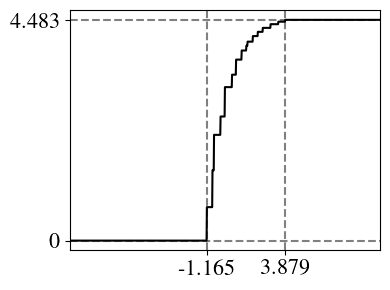

In [2]:
# n = 15
file = log_dir / "optimization_result_NM_n=15.pkl"
try:
    with open(file, "rb") as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = {}
for seed in range(10):
    if str(seed) in results:
        continue
    historic_xks, historic_funs, res = minimize_with_random_initial_simplex(n=15, seed=seed)
    results[str(seed)] = [historic_xks, historic_funs, res]

    with open(file, "wb") as f:
        pickle.dump(results, f)

results_list = [results[str(seed)][2].fun for seed in range(10)]
argmin_seed = np.argmin(results_list)
print(results_list[argmin_seed])
plot_step_function(np.array(results[str(argmin_seed)][2].x), plot_dir / "step_function_NM_n=15.pdf")

### Differential evolution

seed=0, res=[-1.37187704  0.35504311  0.69472238  0.36830311  0.49306822  0.19251644
  0.8481929   0.03904859  0.57057726  0.43373667  0.75638633  0.95439462
  0.46477951  0.51400748  0.67561776  0.05506563  0.49587128  0.23259117
  0.07414733  0.11833685  0.06120539  0.1239364 ], fun=0.760253852969254


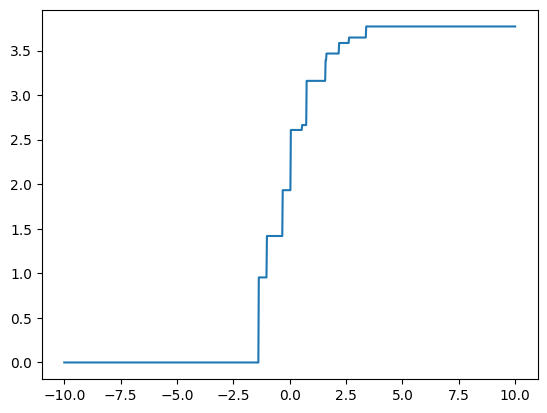

seed=1, res=[-2.84113965  0.79071193  0.20220984  0.35897997  0.693126    0.51994987
  0.33905399  0.4993844   0.69268431  0.78101304  0.80043185  0.67238439
  0.59181274  0.38425463  0.29182983  0.73065236  0.76114114  0.50695156
  0.80896228  0.36885742  0.19193855  0.14959363], fun=0.761111026566141


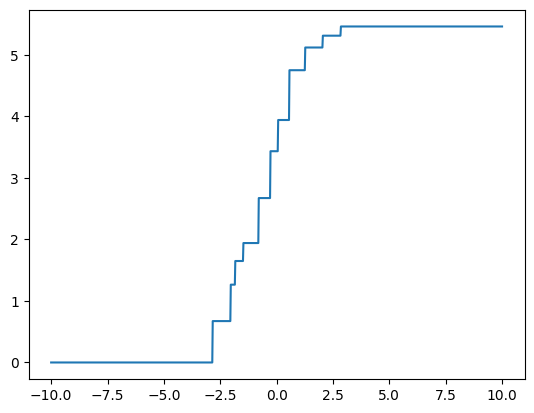

seed=2, res=[-1.74855142  0.17568388  0.36268125  0.328749    0.33776572  0.71305787
  0.79488498  0.57951364  0.29920476  0.60452101  0.49416496  0.65219377
  0.60315464  0.42929662  0.728019    0.70406713  0.99357085  0.25407827
  0.19977445  0.1994584   0.09426604  0.10420009], fun=0.7602189625704342


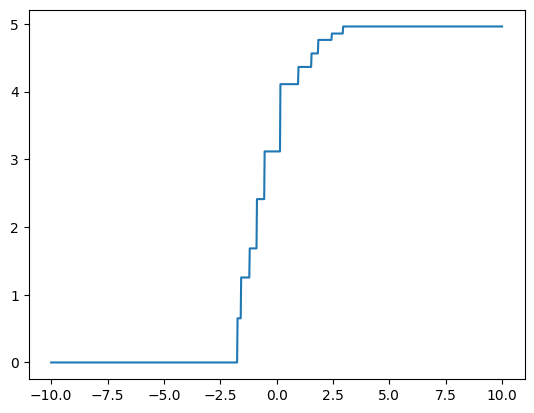

seed=3, res=[-3.21776866  0.87329476  0.35543821  0.42006786  0.76921139  0.5556274
  0.85228647  0.60666912  0.45118798  0.41278479  0.35178428  0.29954064
  0.81839222  0.59352629  0.93514805  0.43181393  0.40430044  0.7263104
  0.33977695  0.14534218  0.07425984  0.15363056], fun=0.7618093674744161


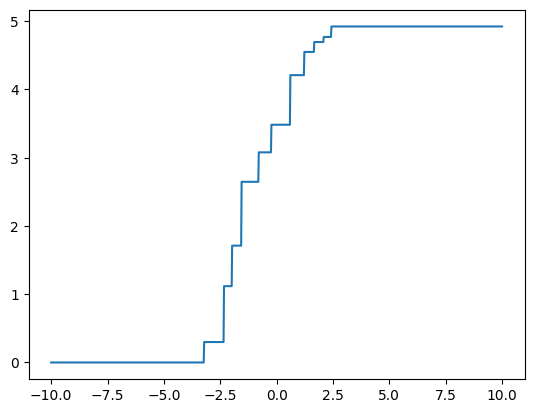

seed=4, res=[-2.4040199   0.11389388  0.88708332  0.47301241  0.67769368  0.16703292
  0.5923118   0.86022606  0.65761205  0.5112346   0.49744462  0.05010638
  0.09524002  0.72225755  0.93948438  0.81925699  0.75749304  0.79477954
  0.36738184  0.15392919  0.1325546   0.04098197], fun=0.7601355526825501


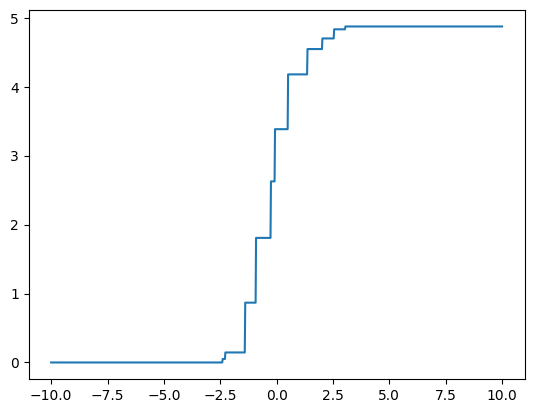

In [6]:
n = 10
bounds = [(-5, 0)] + [(0, 1) for _ in range(1, n + 1)] + [(0, 1) for _ in range(0, n + 1)]
for seed in range(5):
    res = spo.differential_evolution(c_for_step_function, bounds=bounds, seed=seed)
    print(f"seed={seed}, res={res.x}, fun={res.fun}")
    if res.fun < 0.8:
        plot_step_function(res.x)

### Bayesian optimization

seed=0, res=[-1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0.2, 0.13654716159694114, 0.19993005977762435, 0.1895219659984124, 0.2, 0.18941286430514526, 0.025916462412392944, 0.2, 0.15242302154953657, 0.18592515238658497, 0.2, 0.13276981440769153, 0.2, 0.058067539669094906, 0.058009049054601095, 0.0], fun=0.7674768054177549
seed=1, res=[-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0.2, 0.04703555731351545, 0.2, 0.14307905566836496, 0.04224590197497993, 0.04971523022404242, 0.17833168406392955, 0.13087812681456962, 0.03471002521343296, 0.12286165373264615, 0.2, 0.10940179571743945, 0.2, 0.09081448130753911, 0.17648024066350942, 0.2], fun=0.7690365343067244


KeyboardInterrupt: 

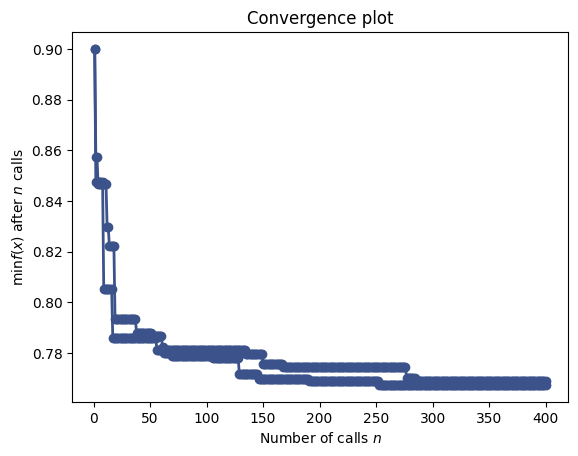

In [8]:
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

n = 15
bounds = [(-5, 0)] + [(0, 1) for _ in range(1, n + 1)] + [(0, 0.2) for _ in range(0, n + 1)]
# Perform Bayesian optimization
for seed in range(5):
    result = gp_minimize(
        c_for_step_function,  # the function to minimize
        bounds,  # the bounds on each dimension of x
        acq_func="EI",  # the acquisition function
        n_calls=400,  # the number of evaluations of f
        n_random_starts=15,  # the number of random initialization points
        random_state=seed,
    )
    print(f"seed={seed}, res={result.x}, fun={result.fun}")
    plot_convergence(result)
    if result.fun < 0.75:
        plot_step_function(result.x, plt.gca())
        plt.show()

# Analyze learned sigma

In [13]:
nn_log_dir = "/cis/home/yma93/projects/gnn-planted-clique/learning_from_data/custom_laplacian"


def analyze_runs(task, model):
    api = wandb.Api()
    runs = api.runs("yuxinma/custom_laplacian")
    try:
        c_criticals = pickle.load(open(log_dir / f"NN_{task}_{model}.pkl", "rb"))
    except FileNotFoundError:
        c_criticals = {}
    for run in runs:
        if not (run.config["task"] == task and run.config["model"]["model"] == model):
            continue
        if run.id in c_criticals:
            critical_result = c_criticals[run.id]
        else:
            fname = glob.glob(os.path.join(nn_log_dir, f"{run.id}/checkpoints/epoch*"))[0]
            best_model = NNTrainingModule.load_from_checkpoint(fname, map_location=None)
            best_model.eval()

            def learned_sigma(x):
                if isinstance(x, (int, float)):
                    input = torch.arange(x - 30, x, 0.01).reshape(-1, 1)
                    input = input.float().to(best_model.device)
                    output = best_model.model.mlp(input).detach().squeeze().cpu().numpy()
                    return output.max()
                if isinstance(x, torch.Tensor) and x.dim() == 1:
                    x_tensor = x.reshape(-1, 1).float().to(best_model.device)
                    output = best_model.model.mlp(x_tensor).detach().squeeze().cpu().numpy()
                    return np.maximum.accumulate(output)

            test_xs = torch.linspace(-100, 100, 1000)
            image = [learned_sigma(test_xs).min().item(), learned_sigma(test_xs).max().item()]
            c_critical_result = c_critical([0.7, 1.3], learned_sigma, sigma_image=image, plot=False)
            c_criticals[run.id] = c_critical_result
            pickle.dump(c_criticals, open(log_dir / f"NN_{task}_{model}.pkl", "wb"))
        print(
            f"run_id={run.id}, test_acc={run.summary['test_acc/dataloader_idx_0']}, large_test_acc={run.summary['large_test_acc']}, c_critical={c_critical_result}"
        )

## Planted Submatrix

In [107]:
analyze_runs("planted_submatrix", "tanh")

/cis/home/yma93/projects/gnn-planted-clique/theoretical_analysis/planted_submatrix_analysis.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


run_id=8f3rwla4, test_acc=0.9275000095367432, large_test_acc=1, c_critical=0.7652338462135958
run_id=wngltvzo, test_acc=0.8399999737739563, large_test_acc=0.48, c_critical=1.0001607849506402
run_id=34ls280o, test_acc=0.9256249666213988, large_test_acc=1, c_critical=0.7580563176426951


/cis/home/yma93/projects/gnn-planted-clique/theoretical_analysis/planted_submatrix_analysis.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(


run_id=diol26d1, test_acc=0.6112499833106995, large_test_acc=0.48, c_critical=1.0000389832177459
run_id=ix66rfao, test_acc=0.9268749952316284, large_test_acc=1, c_critical=0.7640710536998084


/cis/home/yma93/projects/gnn-planted-clique/theoretical_analysis/planted_submatrix_analysis.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return spi.quad(


run_id=nyu3ih04, test_acc=0.9262499809265136, large_test_acc=1, c_critical=0.8370392942448233
run_id=w67emrx0, test_acc=0.9262500405311584, large_test_acc=1, c_critical=0.8206332749217835
run_id=0zegmu8r, test_acc=0.6162499785423279, large_test_acc=0.48, c_critical=1.0000003862605806
run_id=j39yfuyg, test_acc=0.9268749952316284, large_test_acc=1, c_critical=0.8673571283074125
run_id=6btqle4q, test_acc=0.5062500238418579, large_test_acc=0.48, c_critical=1.0007110253678548


In [108]:
analyze_runs("planted_submatrix", "relu")

run_id=fu8t4lk7, test_acc=0.9293749928474426, large_test_acc=1, c_critical=0.7982129310057644
run_id=wc64slhk, test_acc=0.71937495470047, large_test_acc=0.48, c_critical=1.161348646276383
run_id=tjbw3kq9, test_acc=0.9012500047683716, large_test_acc=0.79, c_critical=1.3
run_id=z9cht61s, test_acc=0.625, large_test_acc=0.48, c_critical=0.9999999999989087
run_id=5hxm3lup, test_acc=0.6287500262260437, large_test_acc=0.48, c_critical=0.9999999999989087
run_id=cdey9on6, test_acc=0.9249999523162842, large_test_acc=1, c_critical=0.8578238593847344
run_id=0bb06hl1, test_acc=0.92249995470047, large_test_acc=1, c_critical=1.2479529239415568
run_id=86aagtkc, test_acc=0.6212500333786011, large_test_acc=0.48, c_critical=0.9999999999989087
run_id=ueniolj2, test_acc=0.9231250286102296, large_test_acc=1, c_critical=0.9064734680967377
run_id=soaov8lo, test_acc=0.6168749928474426, large_test_acc=0.48, c_critical=1.3


## Planted Clique

In [104]:
analyze_runs("planted_clique", "tanh")

/cis/home/yma93/projects/gnn-planted-clique/theoretical_analysis/planted_submatrix_analysis.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


run_id=r9daq1yx, test_acc=0.8993749618530273, large_test_acc=1, c_critical=0.7629898698553006


/cis/home/yma93/projects/gnn-planted-clique/theoretical_analysis/planted_submatrix_analysis.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/cis/home/yma93/projects/gnn-planted-clique/theoretical_analysis/planted_submatrix_analysis.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return spi.quad(


run_id=6at5q35k, test_acc=0.6875, large_test_acc=0.58, c_critical=1.3
run_id=ev3o3e1b, test_acc=0.8993749618530273, large_test_acc=1, c_critical=0.7549652937796052
run_id=incc0yzr, test_acc=0.6762500405311584, large_test_acc=1, c_critical=0.9999032986477687
run_id=kgg3maat, test_acc=0.6581249833106995, large_test_acc=1, c_critical=0.9999999999989087
run_id=gb65b3dt, test_acc=0.903124988079071, large_test_acc=1, c_critical=0.7631405286494554
run_id=ohqduzw5, test_acc=0.9024999737739564, large_test_acc=1, c_critical=0.764297329261535
run_id=dos3opzd, test_acc=0.8700000047683716, large_test_acc=1, c_critical=1.3
run_id=9dub6i99, test_acc=0.9018749594688416, large_test_acc=1, c_critical=0.8106357643340741
run_id=rffkncya, test_acc=0.5049999952316284, large_test_acc=1, c_critical=1.0842699083757905


In [105]:
analyze_runs("planted_clique", "relu")

run_id=hie7j5tz, test_acc=0.9012499451637268, large_test_acc=1, c_critical=0.760305921132749
run_id=4utnb6u8, test_acc=0.6831250190734863, large_test_acc=0.68, c_critical=1.3
run_id=9deuluep, test_acc=0.6881250143051147, large_test_acc=0.68, c_critical=1.3
run_id=txhih60g, test_acc=0.6600000262260437, large_test_acc=0.67, c_critical=0.9999999999989087
run_id=n9pr19yb, test_acc=0.6350000500679016, large_test_acc=0.59, c_critical=0.9999999999989087
run_id=a1ukx8qd, test_acc=0.9024999141693116, large_test_acc=1, c_critical=0.8817779860455631
run_id=c3mlr6kb, test_acc=0.9012500047683716, large_test_acc=1, c_critical=0.7783556337457411
run_id=8hl1y9dt, test_acc=0.6506249904632568, large_test_acc=0.69, c_critical=0.9999999973446394
run_id=1fb48kux, test_acc=0.8993749618530273, large_test_acc=1, c_critical=1.0369588891157033
run_id=q9ecy35y, test_acc=0.5049999952316284, large_test_acc=1, c_critical=1.3


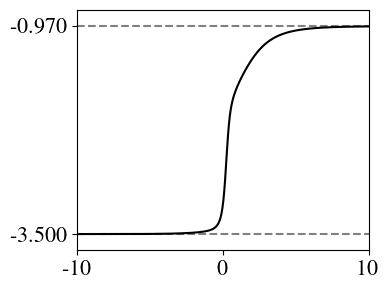

In [14]:
fname = glob.glob(os.path.join(nn_log_dir, f"34ls280o/checkpoints/epoch*"))[0]
best_model = NNTrainingModule.load_from_checkpoint(fname, map_location=None)
best_model.eval()


def learned_sigma(x):
    if isinstance(x, (int, float)):
        input = torch.arange(x - 30, x, 0.01).reshape(-1, 1)
        input = input.float().to(best_model.device)
        output = best_model.model.mlp(input).detach().squeeze().cpu().numpy()
        return output.max()
    if isinstance(x, torch.Tensor) and x.dim() == 1:
        x_tensor = x.reshape(-1, 1).float().to(best_model.device)
        output = best_model.model.mlp(x_tensor).detach().squeeze().cpu().numpy()
        return np.maximum.accumulate(output)


x_s = torch.linspace(-10, 10, 1000)
y_s = learned_sigma(x_s)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x_s, y_s, color="black")
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=16)
ax.set_yticks([y_s[0], y_s[-1]])
ax.set_yticklabels([f"{y_s[0]:.3f}", f"{y_s[-1]:.3f}"], fontsize=16)
ax.hlines(y_s[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(y_s[-1], -10, 10, linestyle="--", color="gray", zorder=1)
ax.set_xlim(-10, 10)
ax.set_ylim(y_s[0] - 0.2, y_s[-1] + 0.2)
fig.tight_layout()
fig.savefig(plot_dir / "mlp_learned_sigma.pdf")
plt.show()